In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import numpy
import torch
from time import time
from tqdm import tqdm

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
cwd = os.getcwd()
NOTEBOOK_DIR = os.path.dirname(cwd+'/')
ROOT = os.path.dirname(NOTEBOOK_DIR)

import sys
sys.path.append(ROOT)

In [4]:
from utils.tools import *

# Constants

In [5]:
INPUT_DIM = 10 #50
BIAS = False

SEED = 42
N_TRAIN = 256
BATCH_SIZE = 64
ALPHA = 1e-1
BASE_LR = 1.0e-2
N_STEPS = int(1.5e3)
N_VAL = 100
VAL_ITER = 100
N_MAX_NEURONS = 2000

EPS = 1.0e-7
ALPHA = 1.0
BETA = 1.0
LAMBDA = 0.02

In [6]:
FIGURES_DIR = os.path.join(ROOT, 'figures/prox_variants/')
create_dir(FIGURES_DIR)

In [7]:
set_random_seeds(SEED)

## Common functions

In [8]:
def forward(a, b, x):
    m = a.shape[1]
    if m == 0:
        return 0.
    return np.matmul(np.maximum(np.matmul(x, b.T), 0), a.T) #/ a.shape[1]

In [9]:
def compute_losses(a, b, x, y, penalized=True):
    y_hat = forward(a, b, x)
    loss_ = 0.5 * np.mean((y_hat - y)**2)
    if penalized:
        penalized_loss = loss_ + LAMBDA * np.sum(np.abs(a))
    else:
        penalized_loss = 0.
    return loss_, penalized_loss

In [10]:
def soft_thresholding(V, tau):
    return - np.sign(V) * np.maximum(0, np.abs(V) - tau)

In [11]:
def V_grad(a, b, x, y, new_b):
    y_hat = forward(a, b, x)
    if len(new_b.shape) < 2:
        new_b = new_b.reshape(1, -1)
    V_grad_ = np.mean((y_hat - y) * np.maximum(np.matmul(x, new_b.T), 0), axis=0)
    if len(V_grad_) == 1:
        return V_grad_[0]
    else:
        return V_grad_

In [12]:
def nabla_V_grad(a, b, x, y):
    n = len(x)
    y_hat = forward(a, b, x)
    M = (y_hat - y) * np.heaviside(np.matmul(x, b.T), 0)
    return np.matmul(M.T, x) / n    

In [13]:
def nabla_V_grad(a, b, x, y, factor=1.0):
    n = len(x)
    m = a.shape[1]
    y_hat = forward(a, b, x)
    # M = (y_hat - y) * np.heaviside(np.matmul(x, b.T * a), 0)
    M = (y_hat - y) * np.heaviside(np.matmul(x, b.T), 0) * factor
    return np.matmul(M.T, x) / n    

In [14]:
#def nabla_V_grad(a, b, x, y):
#    n = len(x)
#    m = a.shape[1]
#    y_hat = forward(a, b, x)
#    # M = (y_hat - y) * np.heaviside(np.matmul(x, b.T * a), 0)
#    M = (y_hat - y) * np.heaviside(np.matmul(x, b.T), 0) * a
#    return np.matmul(M.T, x) / n    

# Data

In [15]:
# Teacher Network
m_star = 50 # 500 # 50 # number of teacher neurons
eps = 3e-1

a_star = 2 * np.sign(np.random.uniform(size=(1, m_star)) - 0.5) / np.sqrt(m_star)
b_star = 2 * np.random.uniform(size=(m_star, INPUT_DIM)) - 1 - eps * np.random.normal(size=(m_star, INPUT_DIM))**2

In [16]:
# Data with inputs on the sphere
x_train = np.random.normal(size=(N_TRAIN, INPUT_DIM))
train_norms = np.linalg.norm(x_train, axis=1, ord=2, keepdims=True)
x_train = x_train / train_norms
y_train = forward(a_star, b_star, x_train)

x_val = np.random.normal(size=(N_VAL, INPUT_DIM))
val_norms = np.linalg.norm(x_val, axis=1, ord=2, keepdims=True)
x_val = x_val / val_norms
y_val = forward(a_star, b_star, x_val)

In [17]:
print(np.max(np.linalg.norm(x_train, axis=1, ord=2)))
print(np.max(np.linalg.norm(x_val, axis=1, ord=2)))

1.0000000000000002
1.0000000000000002


We have
$$V[\mu](b) = \frac{1}{n} \sum_{i=1}^n (f(\mu;x_i) - y_i) \sigma(b^\top x_i).$$
In this setting, sampling the particles on the sphere yields
$$|V[\mu](b) - V[\nu](b)| \leq |\mu - \nu|_{TV},$$
and thus a Lipschitz constant for the gradient $V$ equal to $L=1$. 

## 1. $L^2(\tau)$ proximal algorithm: adding particles

In [18]:
def add_new_neuron(a, b, x, y, eps=1.0e-6):
    new_b = np.random.normal(size=(1, INPUT_DIM))
    neuron_scale = np.linalg.norm(new_b, axis=1, ord=2)
    new_b = new_b / neuron_scale
    V = V_grad(a, b, x, y, new_b)
    new_a = ALPHA * soft_thresholding(V, tau=LAMBDA)
    
    if np.abs(new_a) > eps:
        if a.shape[1] == 0:
            a = np.array([[new_a]])
            b = new_b
        else:
            a = np.column_stack((a, [new_a]))
            b = np.row_stack((b, new_b))
    
    return a, b 

In [19]:
def train(n_steps, x_train, y_train, x_val, y_val, do_val=True):
    a = np.array([[]])
    b = np.array([[]])
    ms = [0]
    train_losses = []
    penalized_train_losses = []
    val_losses = []
    penalized_val_losses = []
    no_change_indexes = []

    for k in tqdm(range(N_STEPS)):
        if a.shape[1] > N_MAX_NEURONS:
            print('-----  BREAKING  -----')
            break
        a, b = add_new_neuron(a, b, x_train, y_train, eps=EPS)
        ms.append(a.shape[1])
        if ms[-1] == ms[-2]:
            no_change_indexes.append(k)
        
        # compute training loss
        train_loss, penalized_train_loss = compute_losses(a, b, x_train, y_train)
        train_losses.append(train_loss)
        penalized_train_losses.append(penalized_train_loss)
        
        # validation loop if do_val is True
        if do_val:
            if k % VAL_ITER == 0:
                val_loss, penalized_val_loss = compute_losses(a, b, x_val, y_val)
                val_losses.append(val_loss)
                penalized_val_losses.append(penalized_val_loss)
                print('m at step {:,} : {:,}'.format(k, ms[-1]))
                print('Train loss at step {:,} : {:.5f}'.format(k, train_loss))
                print('Validation loss at step {:,} : {:.5f}'.format(k, val_loss))
                
    return a, b, np.array(ms), np.array(train_losses), np.array(penalized_train_losses), np.array(val_losses), \
           np.array(penalized_val_losses), np.array(no_change_indexes)

In [20]:
a, b, ms, train_losses_pop, penalized_train_losses_pop, val_losses, penalized_val_losses, no_change_indexes = \
        train(N_STEPS, x_train, y_train, x_val, y_val)

  0%|                                                                             | 0/1500 [00:00<?, ?it/s]

m at step 0 : 1
Train loss at step 0 : 0.46610
Validation loss at step 0 : 0.46041


 32%|████████████████████▋                                            | 476/1500 [00:00<00:00, 2451.43it/s]

m at step 100 : 86
Train loss at step 100 : 0.22937
Validation loss at step 100 : 0.21933
m at step 200 : 141
Train loss at step 200 : 0.18744
Validation loss at step 200 : 0.17869
m at step 300 : 185
Train loss at step 300 : 0.16261
Validation loss at step 300 : 0.15740
m at step 400 : 216
Train loss at step 400 : 0.15163
Validation loss at step 400 : 0.14906
m at step 500 : 246
Train loss at step 500 : 0.14373
Validation loss at step 500 : 0.14203


 48%|███████████████████████████████▎                                 | 722/1500 [00:00<00:00, 1738.54it/s]

m at step 600 : 276
Train loss at step 600 : 0.13566
Validation loss at step 600 : 0.13499
m at step 700 : 305
Train loss at step 700 : 0.12896
Validation loss at step 700 : 0.12891
m at step 800 : 327
Train loss at step 800 : 0.12454
Validation loss at step 800 : 0.12502


 61%|███████████████████████████████████████▋                         | 915/1500 [00:00<00:00, 1289.60it/s]

m at step 900 : 342
Train loss at step 900 : 0.12205
Validation loss at step 900 : 0.12314
m at step 1,000 : 356
Train loss at step 1,000 : 0.11882
Validation loss at step 1,000 : 0.12052


 71%|██████████████████████████████████████████████▏                  | 1066/1500 [00:01<00:00, 634.17it/s]

m at step 1,100 : 366
Train loss at step 1,100 : 0.11736
Validation loss at step 1,100 : 0.11932


 83%|██████████████████████████████████████████████████████▏          | 1251/1500 [00:01<00:00, 438.24it/s]

m at step 1,200 : 383
Train loss at step 1,200 : 0.11476
Validation loss at step 1,200 : 0.11704


 88%|████████████████████████████████████████████████████████▉        | 1315/1500 [00:02<00:00, 383.07it/s]

m at step 1,300 : 394
Train loss at step 1,300 : 0.11273
Validation loss at step 1,300 : 0.11530


100%|█████████████████████████████████████████████████████████████████| 1500/1500 [00:02<00:00, 536.17it/s]

m at step 1,400 : 408
Train loss at step 1,400 : 0.11066
Validation loss at step 1,400 : 0.11362


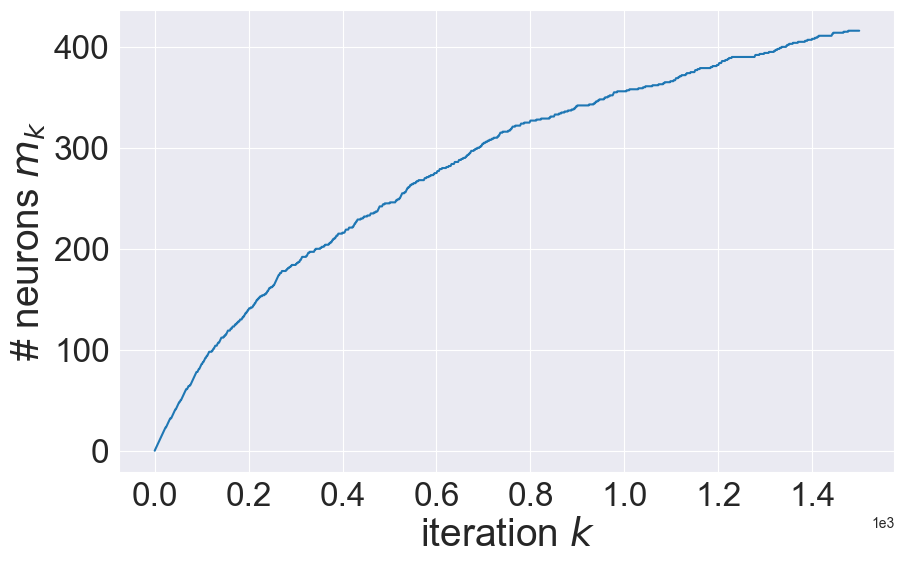

In [21]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(ms)), ms, label='$m_k$')

plt.xlabel('iteration $k$', fontsize=28)
plt.ylabel('# neurons $m_k$', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.savefig(os.path.join(FIGURES_DIR, 'complexity-ista-1-1.png'), bbox_inches='tight')
plt.show()

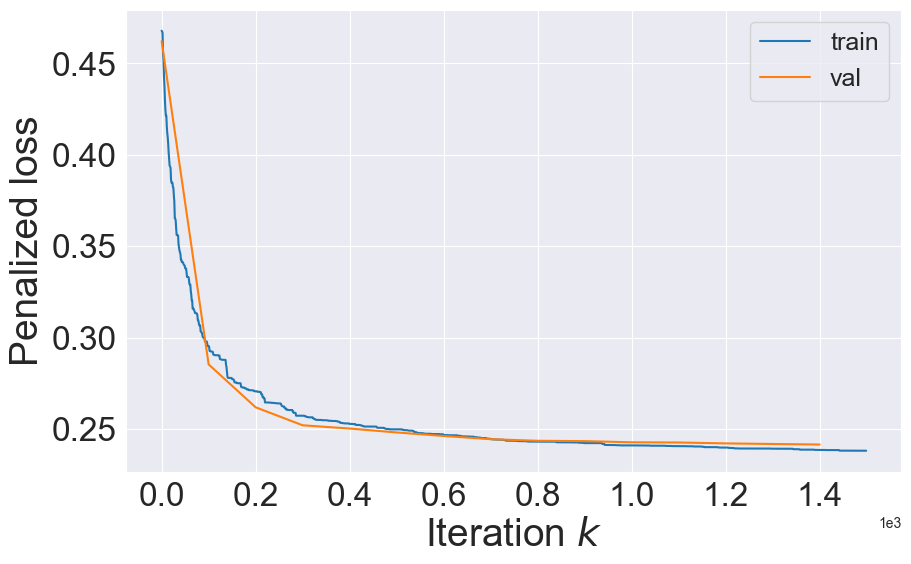

In [22]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(penalized_train_losses_pop)), penalized_train_losses_pop, label='train')
plt.plot([min(VAL_ITER * k, len(penalized_train_losses_pop)) for k in range(len(penalized_val_losses))], 
         penalized_val_losses, label='val', marker=marker)

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Penalized loss', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

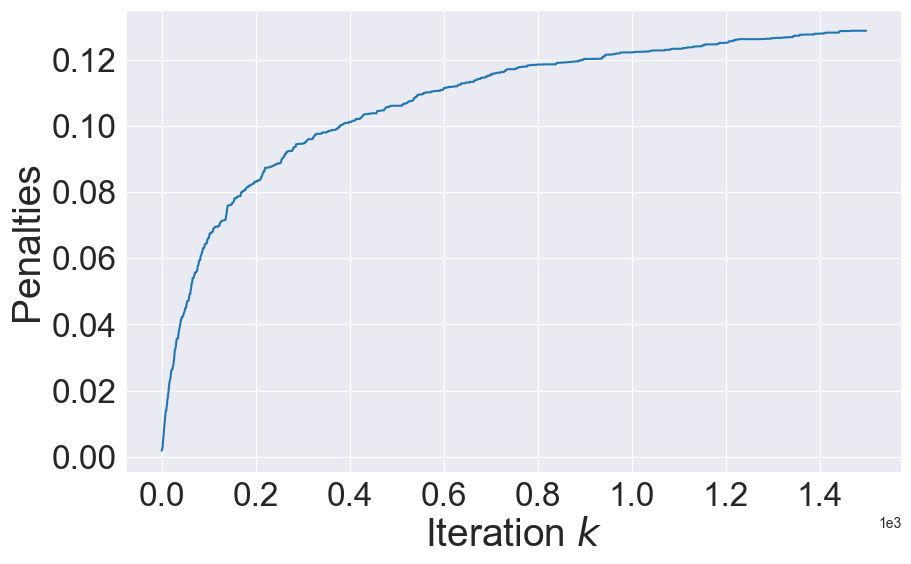

In [23]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

train_penalties = penalized_train_losses_pop - train_losses_pop

plt.plot(np.arange(len(train_penalties)), train_penalties, label='train')

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Penalties', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

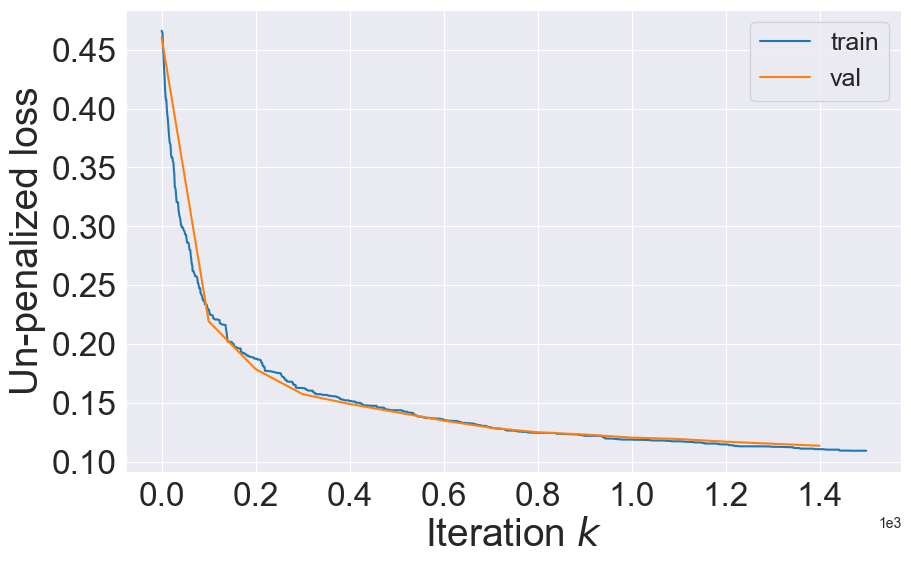

In [24]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(train_losses_pop)), train_losses_pop, label='train')
plt.plot([min(VAL_ITER * k, len(train_losses_pop)) for k in range(len(val_losses))], val_losses, label='val',
         marker=marker)

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Un-penalized loss', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

## 2. $L^2(\tau_m)$ proximal algorithm

Here we sample $m$ neurons $(b_1, \ldots, b_m)$ on the sphere and update their weights via finite-dimensional coordinate descent through the following correspondance:
\begin{align*}
    \mu_a &= \sum_{j=1}^m a_j \delta_{b_j}\\
    f(a) &= J(\mu_a) \\
    g(a) &= \lambda ||a||_1 \\
    F_m(a) &= F(\mu_a) = f(a) +  \lambda ||a||_1\\
    \nabla_j f(a) &= V[\mu_a](b_j) \\
\end{align*}
And $f$ is $L m$-Lipschitz. 

From the $L$-Lipschitzness of $V$ we know that for any $a, b, t$
\begin{align*}
    F_m(a + te_j) = F(\mu_a + t \delta_{b_j}) \leq F_m(a) + V[\mu_a](b_j) t + \frac{L}{2}t^2 + \lambda|t+a_j| - \lambda |a_j|
\end{align*}
In pratice, we do not always have access to the value of $L$, so we choose a step-size $\beta \in (0,1)$, and we have
\begin{align*}
    F_m(a + \beta te_j) \leq F_m(a) + \beta \left[V[\mu_a](b_j) t + \frac{\beta L}{2}t^2 + \lambda\left|t+\frac{a_j}{\beta} \right| \right] - \lambda |a_j|,
\end{align*}
and thus, as soon as $\beta \leq 1/L$ we can virtually replace the initial $L$ by $1$ and $a_j$ by $a_j / \beta$ since
\begin{align*}
    F_m(a + \beta te_j) \leq F_m(a) + \beta \left[V[\mu_a](b_j) t + \frac{t^2}{2} + \lambda\left|t+\frac{a_j}{\beta} \right| \right] - \lambda |a_j|.
\end{align*}
The update for the sampled coordinate $j$ thus reads
\begin{align*}
    a_j &\leftarrow a_j + \beta t_j^* \\
    t_j^* :&= \text{argmin}_{t} \left(V[\mu_a](b_j) t + \frac{t^2}{2} + \lambda\left|t+\frac{a_j}{\beta} \right| \right) = -\frac{a_j}{\beta} - \text{sign}\left(V[\mu_a](b_j) - \frac{a_j}{\beta} \right) \max \left(0, \left|V[\mu_a](b_j) - \frac{a_j}{\beta} \right| - \lambda \right),
\end{align*}
which gives 
\begin{align*}
    a_j &\leftarrow - \beta \text{sign}\left(V[\mu_a](b_j) - \frac{a_j}{\beta} \right) \max \left(0, \left|V[\mu_a](b_j) - \frac{a_j}{\beta} \right| - \lambda \right)
\end{align*}

In [25]:
n_steps = N_STEPS
m = 500
BETA = 1.0

In [26]:
def update_random_neuron(m, a, b, x, y, eps=1.0e-9):
    if a.shape[1] > 0:
        j = np.random.randint(low=0, high=m)
        b_j = b[j, :].reshape(1, -1)
        V = V_grad(a, b, x, y, b_j) - a[0, j] / BETA 
        new_a = BETA * soft_thresholding(V, tau=LAMBDA)
        a[0, j] = new_a  

        #if np.abs(new_a) > eps:
            # update weight for neuron b_j
        #    a[0, j] = new_a  
        #else:
            # remove a_j and b_j from the list
            # a = np.column_stack((a[:, :j], a[:, j+1:]))
            # b = np.row_stack((b[:j, :], b[j+1:, :]))
        #    a[0, j] = 0. 
    return a, b  

In [27]:
def train(m, n_steps, x_train, y_train, x_val, y_val, do_val=True):
    a = np.zeros(shape=(1, m))
    b = np.random.normal(size=(m, INPUT_DIM))
    b_norms = np.linalg.norm(b, axis=1, ord=2, keepdims=True)
    b = b / b_norms
    b_0 = np.copy(b)
    
    ms = [m]
    train_losses = []
    penalized_train_losses = []
    val_losses = []
    penalized_val_losses = []
    where_decrease_indexes = []

    for k in tqdm(range(N_STEPS)):
        a, b = update_random_neuron(m, a, b, x_train, y_train, eps=1e-9)
        ms.append(a.shape[1])
        if ms[-1] == ms[-2]-1:
            where_decrease_indexes.append(k)
        
        # compute training loss
        train_loss, penalized_train_loss = compute_losses(a, b, x_train, y_train)
        train_losses.append(train_loss)
        penalized_train_losses.append(penalized_train_loss)
        
        # validation loop if do_val is True
        if do_val:
            if k % VAL_ITER == 0:
                val_loss, penalized_val_loss = compute_losses(a, b, x_val, y_val)
                val_losses.append(val_loss)
                penalized_val_losses.append(penalized_val_loss)
                print('m at step {:,} : {:,}'.format(k, ms[-1]))
                print('Train loss at step {:,} : {:.5f}'.format(k, train_loss))
                print('Validation loss at step {:,} : {:.5f}'.format(k, val_loss))
                
    return a, b, b_0, np.array(ms), np.array(train_losses), np.array(penalized_train_losses), np.array(val_losses), \
           np.array(penalized_val_losses), np.array(where_decrease_indexes)

In [28]:
a, b, b_0, ms, train_losses_coord, penalized_train_losses_coord, val_losses, penalized_val_losses, \
    where_decrease_indexes = train(m, n_steps, x_train, y_train, x_val, y_val)

  1%|▊                                                                   | 18/1500 [00:00<00:15, 98.10it/s]

m at step 0 : 500
Train loss at step 0 : 0.47413
Validation loss at step 0 : 0.46550


 10%|██████▊                                                           | 156/1500 [00:00<00:04, 268.89it/s]

m at step 100 : 500
Train loss at step 100 : 0.24098
Validation loss at step 100 : 0.23498


 18%|████████████                                                      | 275/1500 [00:01<00:03, 344.18it/s]

m at step 200 : 500
Train loss at step 200 : 0.18567
Validation loss at step 200 : 0.18334
m at step 300 : 500
Train loss at step 300 : 0.16743
Validation loss at step 300 : 0.17008


 34%|██████████████████████▏                                           | 503/1500 [00:01<00:01, 508.36it/s]

m at step 400 : 500
Train loss at step 400 : 0.15237
Validation loss at step 400 : 0.15738
m at step 500 : 500
Train loss at step 500 : 0.14084
Validation loss at step 500 : 0.14840


 55%|████████████████████████████████████▌                             | 831/1500 [00:02<00:01, 573.19it/s]

m at step 600 : 500
Train loss at step 600 : 0.13504
Validation loss at step 600 : 0.14275
m at step 700 : 500
Train loss at step 700 : 0.12917
Validation loss at step 700 : 0.13813
m at step 800 : 500
Train loss at step 800 : 0.12565
Validation loss at step 800 : 0.13519


 74%|███████████████████████████████████████████████▉                 | 1106/1500 [00:02<00:00, 892.67it/s]

m at step 900 : 500
Train loss at step 900 : 0.12222
Validation loss at step 900 : 0.13089
m at step 1,000 : 500
Train loss at step 1,000 : 0.11698
Validation loss at step 1,000 : 0.12621
m at step 1,100 : 500
Train loss at step 1,100 : 0.11381
Validation loss at step 1,100 : 0.12334


 93%|███████████████████████████████████████████████████████████▋    | 1398/1500 [00:02<00:00, 1149.52it/s]

m at step 1,200 : 500
Train loss at step 1,200 : 0.11094
Validation loss at step 1,200 : 0.12061
m at step 1,300 : 500
Train loss at step 1,300 : 0.10834
Validation loss at step 1,300 : 0.11819
m at step 1,400 : 500
Train loss at step 1,400 : 0.10691
Validation loss at step 1,400 : 0.11624


100%|█████████████████████████████████████████████████████████████████| 1500/1500 [00:02<00:00, 562.22it/s]


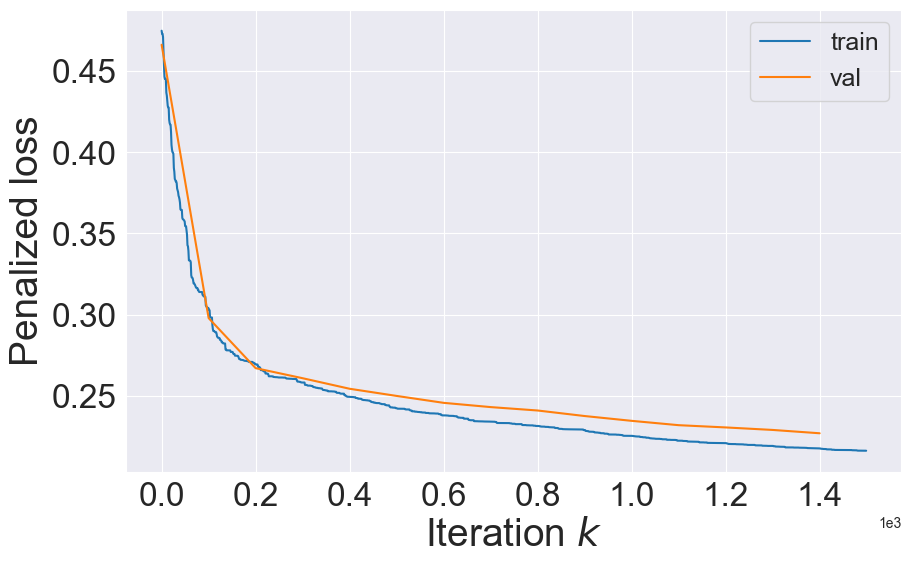

In [29]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(penalized_train_losses_coord)), penalized_train_losses_coord, label='train')
plt.plot([min(VAL_ITER * k, len(penalized_train_losses_coord)) for k in range(len(penalized_val_losses))], 
         penalized_val_losses, label='val', marker=marker)

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Penalized loss', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

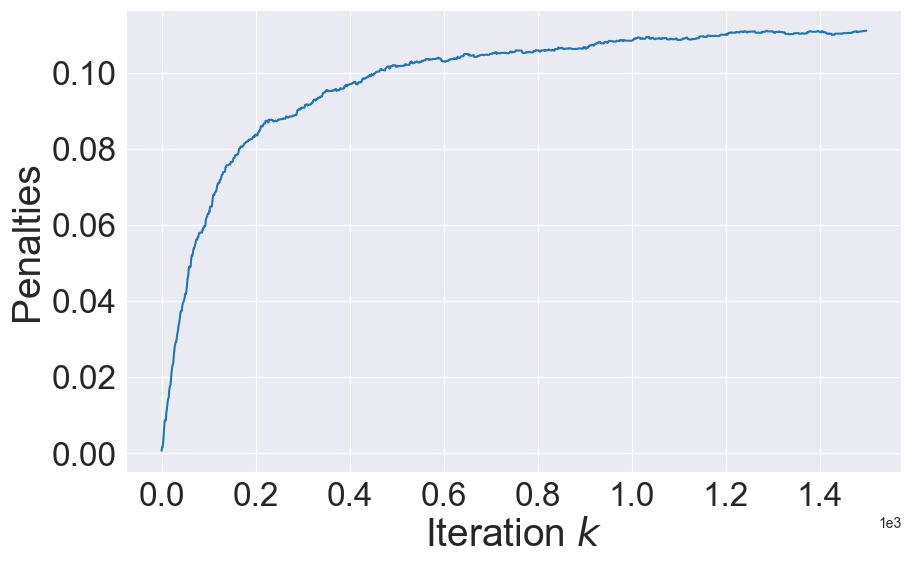

In [30]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

train_penalties = penalized_train_losses_coord - train_losses_coord

plt.plot(np.arange(len(train_penalties)), train_penalties, label='train')

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Penalties', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

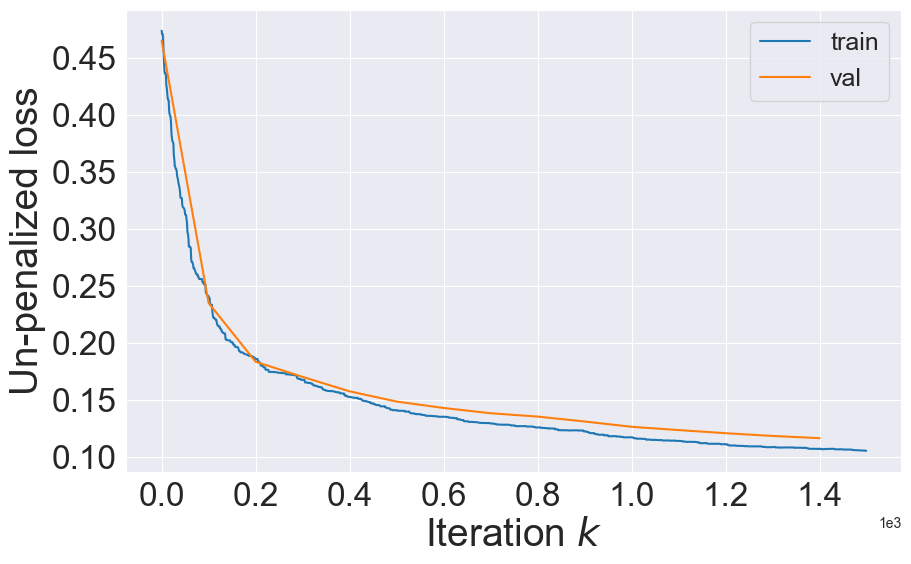

In [31]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(train_losses_coord)), train_losses_coord, label='train')
plt.plot([min(VAL_ITER * k, len(train_losses_coord)) for k in range(len(val_losses))], val_losses, label='val',
         marker=marker)

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Un-penalized loss', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

## 3. Projected conic descent

In [32]:
n_steps = N_STEPS
m = 500
ETA = 0.01
penalized = True

In [33]:
def projected_conic_particle_update(a, b, x, y, penalized=False):
    m = a.shape[1]
    if m > 0:
        signs = np.sign(a)
        a = a * (1 - 2 * ETA * signs * V_grad(a, b, x, y, b).reshape(1, -1))
        b = b - ETA * signs.T * nabla_V_grad(a, b, x, y)
        
        if penalized:
            a -= 2 * ETA * LAMBDA * a
            b -= ETA * LAMBDA * b
        
        b_norms = np.linalg.norm(b, ord=2, axis=1, keepdims=True)
        b = b / b_norms
    return a, b  

In [34]:
def train(m, n_steps, x_train, y_train, x_val, y_val, do_val=True, penalized=False):
    #a = np.zeros(shape=(1, m))
    a = np.random.normal(size=(1, m)) / m
    b = np.random.normal(size=(m, INPUT_DIM))
    b_norms = np.linalg.norm(b, axis=1, ord=2, keepdims=True)
    b = b / b_norms
    
    train_losses = []
    penalized_train_losses = []
    val_losses = []
    penalized_val_losses = []
    ms = [m]

    for k in tqdm(range(n_steps)):
        a, b = projected_conic_particle_update(a, b, x_train, y_train, penalized=penalized)
        ms.append(a.shape[1])
        
        train_loss, penalized_train_loss = compute_losses(a, b, x_train, y_train)
        train_losses.append(train_loss)
        penalized_train_losses.append(penalized_train_loss)
        
        # validation loop if do_val is True
        if do_val:
            if k % VAL_ITER == 0:
                val_loss, penalized_val_loss = compute_losses(a, b, x_val, y_val)
                val_losses.append(val_loss)
                penalized_val_losses.append(penalized_val_loss)
                print('m at step {:,} : {:,}'.format(k, ms[-1]))
                print('Train loss at step {:,} : {:.5f}'.format(k, train_loss))
                print('Validation loss at step {:,} : {:.5f}'.format(k, val_loss))
                
    return a, b, np.array(ms), np.array(train_losses), np.array(penalized_train_losses), np.array(val_losses), \
           np.array(penalized_val_losses) 

In [35]:
a, b, ms, train_losses_conic, penalized_train_losses_conic, val_losses_conic, penalized_val_losses_conic = \
    train(m, n_steps, x_train, y_train, x_val, y_val, penalized=penalized)

  2%|█▍                                                                 | 31/1500 [00:00<00:04, 303.25it/s]

m at step 0 : 500
Train loss at step 0 : 0.47608
Validation loss at step 0 : 0.46829


  8%|█████▌                                                            | 125/1500 [00:01<00:13, 102.02it/s]

m at step 100 : 500
Train loss at step 100 : 0.45595
Validation loss at step 100 : 0.44959


 14%|█████████▍                                                         | 212/1500 [00:02<00:13, 95.83it/s]

m at step 200 : 500
Train loss at step 200 : 0.43622
Validation loss at step 200 : 0.43147


 24%|███████████████▋                                                  | 356/1500 [00:02<00:04, 260.53it/s]

m at step 300 : 500
Train loss at step 300 : 0.41503
Validation loss at step 300 : 0.41227


 30%|████████████████████                                              | 455/1500 [00:02<00:03, 303.76it/s]

m at step 400 : 500
Train loss at step 400 : 0.39099
Validation loss at step 400 : 0.39079


 37%|████████████████████████▋                                         | 561/1500 [00:03<00:02, 333.82it/s]

m at step 500 : 500
Train loss at step 500 : 0.36334
Validation loss at step 500 : 0.36631


 42%|███████████████████████████▋                                      | 629/1500 [00:03<00:02, 314.54it/s]

m at step 600 : 500
Train loss at step 600 : 0.33198
Validation loss at step 600 : 0.33861


 48%|███████████████████████████████▌                                  | 716/1500 [00:03<00:03, 233.97it/s]

m at step 700 : 500
Train loss at step 700 : 0.29774
Validation loss at step 700 : 0.30819


 55%|████████████████████████████████████                              | 821/1500 [00:04<00:03, 208.74it/s]

m at step 800 : 500
Train loss at step 800 : 0.26229
Validation loss at step 800 : 0.27628


 62%|█████████████████████████████████████████▏                        | 936/1500 [00:05<00:03, 172.21it/s]

m at step 900 : 500
Train loss at step 900 : 0.22794
Validation loss at step 900 : 0.24466


 70%|█████████████████████████████████████████████▍                   | 1048/1500 [00:05<00:01, 262.98it/s]

m at step 1,000 : 500
Train loss at step 1,000 : 0.19692
Validation loss at step 1,000 : 0.21517


 74%|████████████████████████████████████████████████▍                | 1117/1500 [00:05<00:01, 297.89it/s]

m at step 1,100 : 500
Train loss at step 1,100 : 0.17070
Validation loss at step 1,100 : 0.18918


 82%|█████████████████████████████████████████████████████            | 1224/1500 [00:06<00:01, 215.39it/s]

m at step 1,200 : 500
Train loss at step 1,200 : 0.14973
Validation loss at step 1,200 : 0.16732


 88%|█████████████████████████████████████████████████████████▉        | 1318/1500 [00:07<00:01, 94.24it/s]

m at step 1,300 : 500
Train loss at step 1,300 : 0.13359
Validation loss at step 1,300 : 0.14956


 96%|██████████████████████████████████████████████████████████████▎  | 1438/1500 [00:08<00:00, 224.64it/s]

m at step 1,400 : 500
Train loss at step 1,400 : 0.12142
Validation loss at step 1,400 : 0.13541


100%|█████████████████████████████████████████████████████████████████| 1500/1500 [00:08<00:00, 182.06it/s]


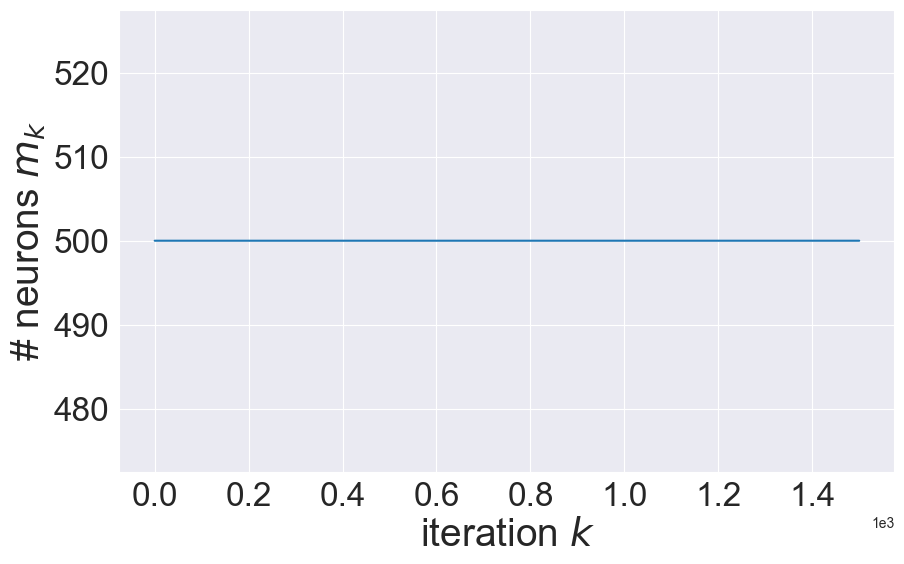

In [36]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(ms)), ms, label='$m_k$')

plt.xlabel('iteration $k$', fontsize=28)
plt.ylabel('# neurons $m_k$', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.savefig(os.path.join(FIGURES_DIR, 'complexity-ista-1-1.png'), bbox_inches='tight')
plt.show()

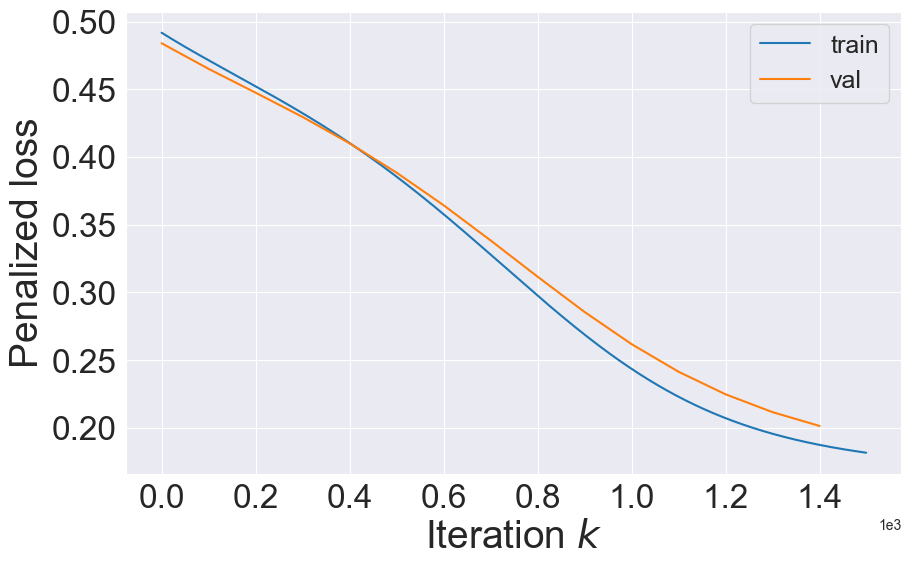

In [37]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(penalized_train_losses_conic)), penalized_train_losses_conic, label='train')
plt.plot([min(VAL_ITER * k, len(penalized_train_losses_conic)) for k in range(len(penalized_val_losses_conic))], 
         penalized_val_losses_conic, label='val', marker=marker)

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Penalized loss', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

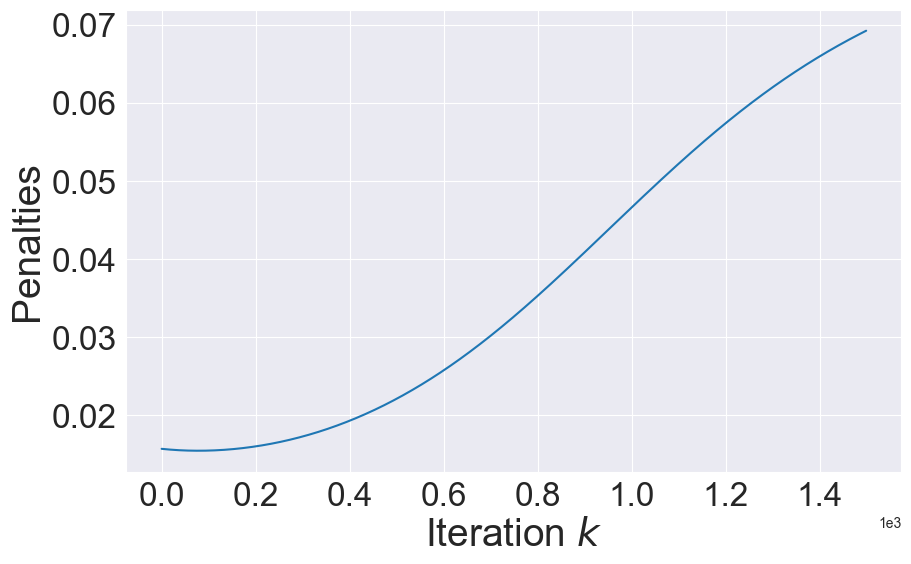

In [38]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

train_penalties = penalized_train_losses_conic - train_losses_conic

plt.plot(np.arange(len(train_penalties)), train_penalties, label='train')

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Penalties', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

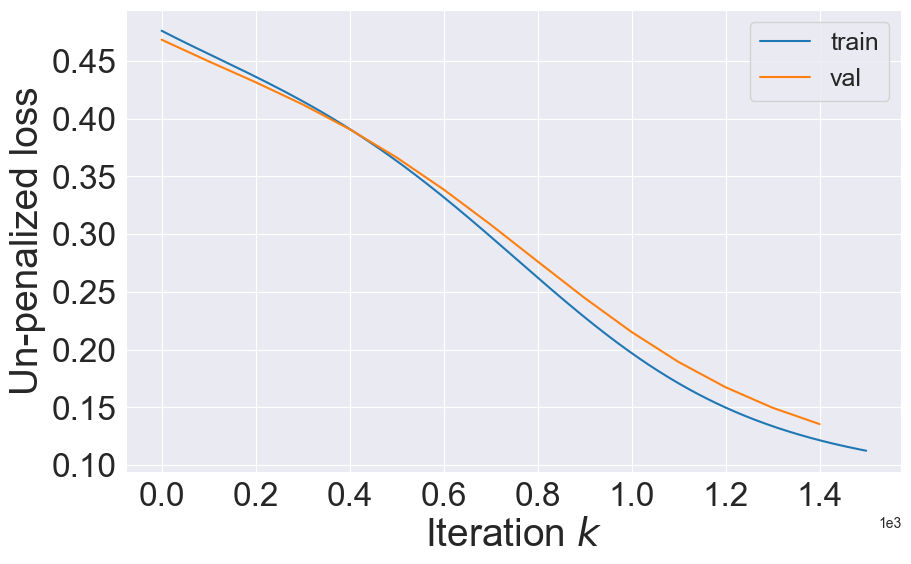

In [39]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(train_losses_conic)), train_losses_conic, label='train')
plt.plot([min(VAL_ITER * k, len(train_losses_conic)) for k in range(len(val_losses_conic))], val_losses_conic,
         label='val', marker=marker)

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Un-penalized loss', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

## 4. Mix $L^2(\tau)/L^2(\tau_m)$ proximal algorithm

Here we mix one step of sampling a new particle and adjusting its weight and one step of chosing an existing particle at random and updating its weight. 

In [40]:
n_steps = N_STEPS
m = 500
ALPHA = 1.0
BETA = 1.0

In [41]:
def update_random_neuron(a, b, x, y, eps=1.0e-9):
    if a.shape[1] > 0:
        j = np.random.randint(low=0, high=a.shape[1])
        b_j = b[j, :].reshape(1, -1)
        V = V_grad(a, b, x, y, b_j) - a[0, j] / BETA 
        new_a = BETA * soft_thresholding(V, tau=LAMBDA)

        if np.abs(new_a) > 0:
            # update weight for neuron b_j
            a[0, j] = new_a  
        else:
            # remove a_j and b_j from the list
            a = np.column_stack((a[:, :j], a[:, j+1:]))
            b = np.row_stack((b[:j, :], b[j+1:, :]))
        #    a[0, j] = 0. 
    return a, b  

In [42]:
def train(n_steps, x_train, y_train, x_val, y_val, do_val=True):
    a = np.array([[]])
    b = np.array([[]])
    ms = [0]
    train_losses = []
    penalized_train_losses = []
    val_losses = []
    penalized_val_losses = []

    for k in tqdm(range(n_steps)):
        if k % 2 == 0:
            # sample new particle and set weight
            a, b = add_new_neuron(a, b, x_train, y_train, eps=1e-8)
            ms.append(a.shape[1])
            # compute training loss
            train_loss, penalized_train_loss = compute_losses(a, b, x_train, y_train)
            train_losses.append(train_loss)
            penalized_train_losses.append(penalized_train_loss)
        else:
            # update existing particle
            a, b = update_random_neuron(a, b, x_train, y_train, eps=1e-8)
            ms.append(a.shape[1])
            # compute training loss
            train_loss, penalized_train_loss = compute_losses(a, b, x_train, y_train)
            train_losses.append(train_loss)
            penalized_train_losses.append(penalized_train_loss)
        
        # validation loop if do_val is True
        if do_val:
            if k % VAL_ITER == 0:
                val_loss, penalized_val_loss = compute_losses(a, b, x_val, y_val)
                val_losses.append(val_loss)
                penalized_val_losses.append(penalized_val_loss)
                print('m at step {:,} : {:,}'.format(k, ms[-1]))
                print('Train loss at step {:,} : {:.5f}'.format(k, train_loss))
                print('Validation loss at step {:,} : {:.5f}'.format(k, val_loss))
                
    return a, b, np.array(ms), np.array(train_losses), np.array(penalized_train_losses), np.array(val_losses), \
           np.array(penalized_val_losses) 

In [43]:
a, b, ms, train_losses_mix, penalized_train_losses_mix, val_losses, penalized_val_losses = \
        train(n_steps, x_train, y_train, x_val, y_val)

 30%|███████████████████▍                                             | 449/1500 [00:00<00:00, 4481.32it/s]

m at step 0 : 1
Train loss at step 0 : 0.46201
Validation loss at step 0 : 0.45343
m at step 100 : 36
Train loss at step 100 : 0.21661
Validation loss at step 100 : 0.20126
m at step 200 : 56
Train loss at step 200 : 0.17679
Validation loss at step 200 : 0.15889
m at step 300 : 70
Train loss at step 300 : 0.15660
Validation loss at step 300 : 0.14157
m at step 400 : 77
Train loss at step 400 : 0.14186
Validation loss at step 400 : 0.13305
m at step 500 : 88
Train loss at step 500 : 0.13185
Validation loss at step 500 : 0.12462
m at step 600 : 95
Train loss at step 600 : 0.12248
Validation loss at step 600 : 0.11614
m at step 700 : 96
Train loss at step 700 : 0.11737
Validation loss at step 700 : 0.11162
m at step 800 : 100
Train loss at step 800 : 0.11192
Validation loss at step 800 : 0.10710


100%|████████████████████████████████████████████████████████████████| 1500/1500 [00:00<00:00, 3750.03it/s]

m at step 900 : 100
Train loss at step 900 : 0.11045
Validation loss at step 900 : 0.10618
m at step 1,000 : 107
Train loss at step 1,000 : 0.10865
Validation loss at step 1,000 : 0.10522
m at step 1,100 : 103
Train loss at step 1,100 : 0.10619
Validation loss at step 1,100 : 0.10309
m at step 1,200 : 104
Train loss at step 1,200 : 0.10417
Validation loss at step 1,200 : 0.10226
m at step 1,300 : 103
Train loss at step 1,300 : 0.10254
Validation loss at step 1,300 : 0.10009
m at step 1,400 : 99
Train loss at step 1,400 : 0.10097
Validation loss at step 1,400 : 0.09862


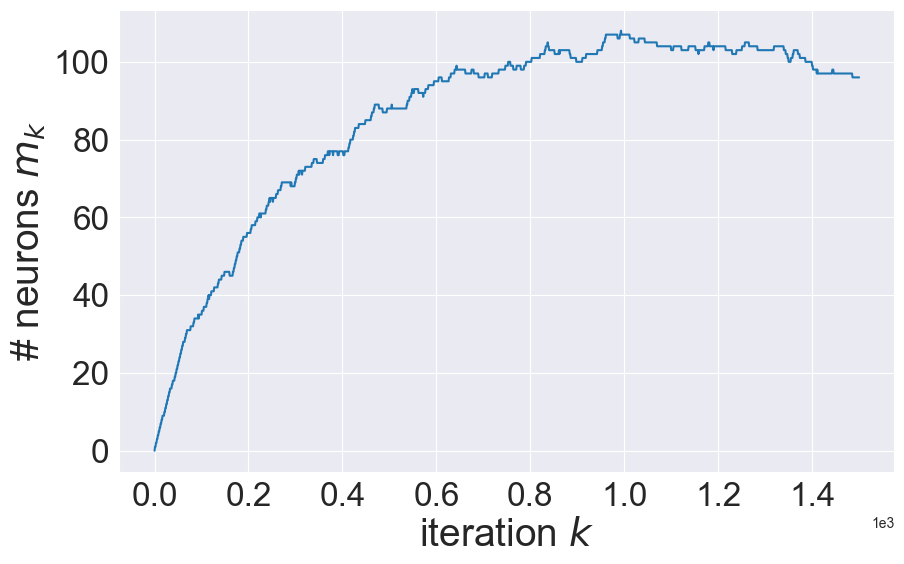

In [44]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(ms)), ms, label='$m_k$')

plt.xlabel('iteration $k$', fontsize=28)
plt.ylabel('# neurons $m_k$', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.savefig(os.path.join(FIGURES_DIR, 'complexity-ista-1-1.png'), bbox_inches='tight')
plt.show()

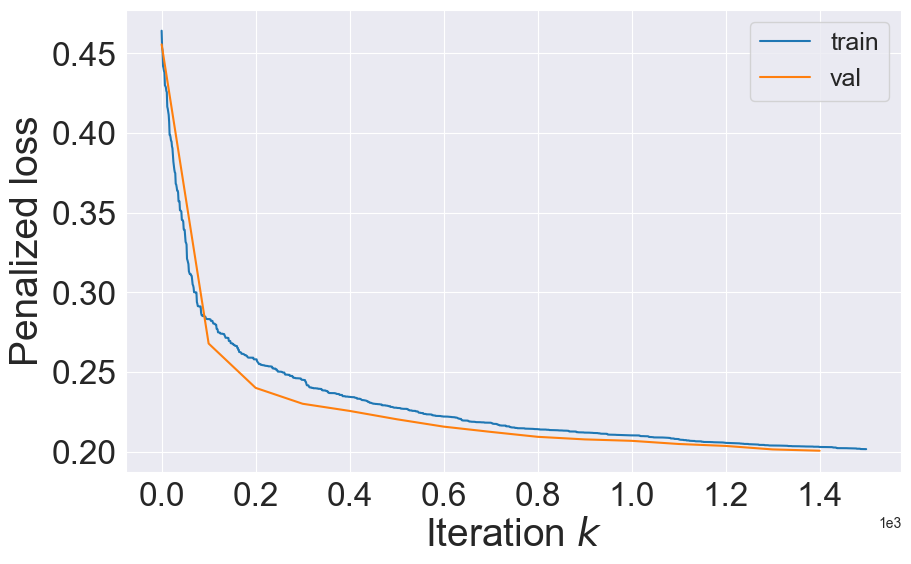

In [45]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(penalized_train_losses_mix)), penalized_train_losses_mix, label='train')
plt.plot([min(VAL_ITER * k, len(penalized_train_losses_mix)) for k in range(len(penalized_val_losses))], 
         penalized_val_losses, label='val', marker=marker)

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Penalized loss', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

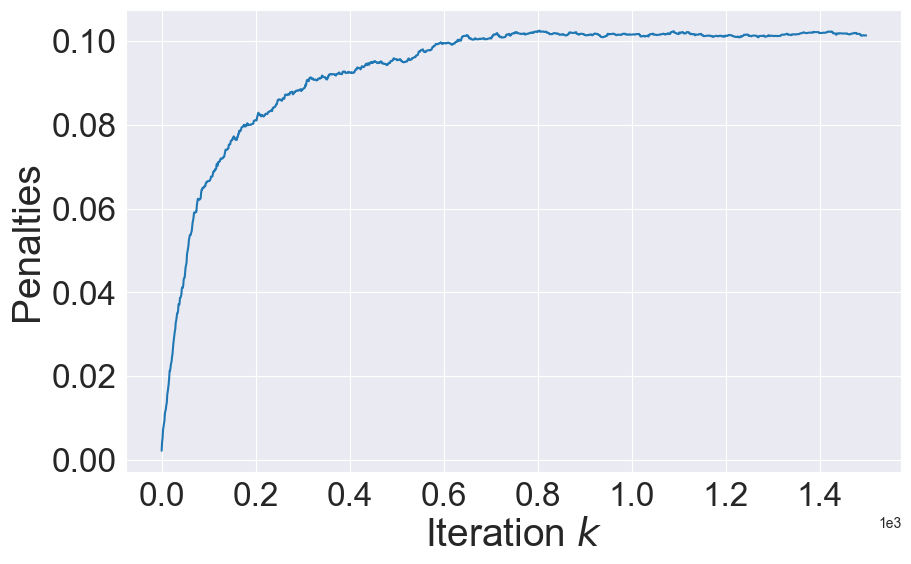

In [46]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

train_penalties = penalized_train_losses_mix - train_losses_mix

plt.plot(np.arange(len(train_penalties)), train_penalties, label='train')

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Penalties', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

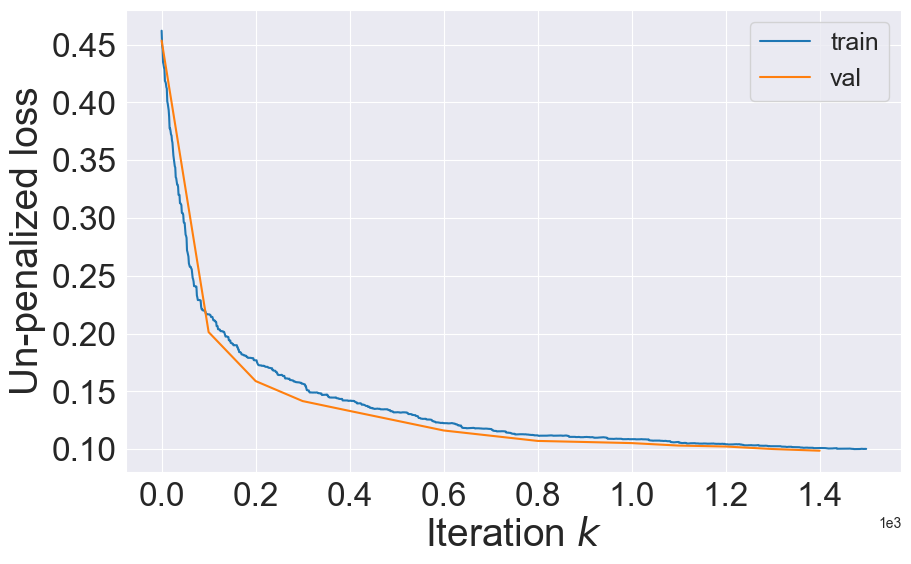

In [47]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(train_losses_mix)), train_losses_mix, label='train')
plt.plot([min(VAL_ITER * k, len(train_losses_mix)) for k in range(len(val_losses))], val_losses, label='val',
         marker=marker)

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Un-penalized loss', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

## 5. Mix $L^2(\tau)/L^2(\tau_m)/\text{conic-GD}$ algorithm

In [48]:
n_steps = N_STEPS
m = 500
ALPHA = 1.0
BETA = 1.0
ETA = 0.01
penalized = True

In [49]:
def update_random_neuron(a, b, x, y, eps=1.0e-9):
    if a.shape[1] > 0:
        j = np.random.randint(low=0, high=a.shape[1])
        b_j = b[j, :].reshape(1, -1)
        V = V_grad(a, b, x, y, b_j) - a[0, j] / BETA 
        new_a = BETA * soft_thresholding(V, tau=LAMBDA)

        if np.abs(new_a) > 0:
            # update weight for neuron b_j
            a[0, j] = new_a  
        else:
            # remove a_j and b_j from the list
            a = np.column_stack((a[:, :j], a[:, j+1:]))
            b = np.row_stack((b[:j, :], b[j+1:, :]))
        #    a[0, j] = 0. 
    return a, b  

In [50]:
#def projected_conic_particle_update(a, b, x, y, penalized=False):
#    m = a.shape[1]
#    if m > 0:
#        #a = a - ETA * V_grad(a, b, x, y, b).reshape(1, -1) / m
#        #b = b - m * ETA * nabla_V_grad(a, b, x, y, factor=a)
#        a = a - ETA * V_grad(a, b, x, y, b).reshape(1, -1)
#        b = b - ETA * nabla_V_grad(a, b, x, y, factor=a)
#        
#        if penalized:
#            a = a - ETA * LAMBDA * np.sign(a)
#        
#        b_norms = np.linalg.norm(b, ord=2, axis=1, keepdims=True)
#        # a = a * b_norms.T
#        b = b / b_norms
#    return a, b

In [51]:
def train(n_steps, x_train, y_train, x_val, y_val, do_val=True, penalized=False):
    a = np.array([[]])
    b = np.array([[]])
    ms = [0]
    train_losses = []
    penalized_train_losses = []
    val_losses = []
    penalized_val_losses = []

    for k in tqdm(range(n_steps)):
        if k % 3 == 0:
            # sample new particle and set weight
            a, b = add_new_neuron(a, b, x_train, y_train, eps=1e-8)
            ms.append(a.shape[1])
            # compute training loss
            train_loss, penalized_train_loss = compute_losses(a, b, x_train, y_train)
            train_losses.append(train_loss)
            penalized_train_losses.append(penalized_train_loss)
        elif k % 3 == 1:
            # update existing particle
            a, b = update_random_neuron(a, b, x_train, y_train, eps=1e-8)
            ms.append(a.shape[1])
            # compute training loss
            train_loss, penalized_train_loss = compute_losses(a, b, x_train, y_train)
            train_losses.append(train_loss)
            penalized_train_losses.append(penalized_train_loss)
        else:
            # do conic-GD update
            a, b = projected_conic_particle_update(a, b, x_train, y_train, penalized=penalized)
            ms.append(a.shape[1])
            # compute training loss
            train_loss, penalized_train_loss = compute_losses(a, b, x_train, y_train)
            train_losses.append(train_loss)
            penalized_train_losses.append(penalized_train_loss)
        
        # validation loop if do_val is True
        if do_val:
            if k % VAL_ITER == 0:
                val_loss, penalized_val_loss = compute_losses(a, b, x_val, y_val)
                val_losses.append(val_loss)
                penalized_val_losses.append(penalized_val_loss)
                print('m at step {:,} : {:,}'.format(k, ms[-1]))
                print('Train loss at step {:,} : {:.5f}'.format(k, train_loss))
                print('Validation loss at step {:,} : {:.5f}'.format(k, val_loss))
                
    return a, b, np.array(ms), np.array(train_losses), np.array(penalized_train_losses), np.array(val_losses), \
           np.array(penalized_val_losses) 

In [52]:
a, b, ms, train_losses_mix_conic, penalized_train_losses_mix_conic, val_losses, penalized_val_losses = \
        train(n_steps, x_train, y_train, x_val, y_val, penalized=penalized)

 25%|███████████████▉                                                 | 368/1500 [00:00<00:00, 1817.51it/s]

m at step 0 : 1
Train loss at step 0 : 0.46587
Validation loss at step 0 : 0.45260
m at step 100 : 31
Train loss at step 100 : 0.27156
Validation loss at step 100 : 0.25993
m at step 200 : 51
Train loss at step 200 : 0.19726
Validation loss at step 200 : 0.18786
m at step 300 : 70
Train loss at step 300 : 0.15856
Validation loss at step 300 : 0.15430


 50%|████████████████████████████████▍                                | 749/1500 [00:00<00:00, 1871.68it/s]

m at step 400 : 77
Train loss at step 400 : 0.13876
Validation loss at step 400 : 0.13691
m at step 500 : 82
Train loss at step 500 : 0.12224
Validation loss at step 500 : 0.12277
m at step 600 : 86
Train loss at step 600 : 0.11279
Validation loss at step 600 : 0.11430
m at step 700 : 91
Train loss at step 700 : 0.10408
Validation loss at step 700 : 0.10763


 75%|███████████████████████████████████████████████▉                | 1124/1500 [00:00<00:00, 1815.90it/s]

m at step 800 : 94
Train loss at step 800 : 0.09832
Validation loss at step 800 : 0.10267
m at step 900 : 96
Train loss at step 900 : 0.09446
Validation loss at step 900 : 0.09930
m at step 1,000 : 96
Train loss at step 1,000 : 0.09079
Validation loss at step 1,000 : 0.09615
m at step 1,100 : 94
Train loss at step 1,100 : 0.08865
Validation loss at step 1,100 : 0.09406


100%|████████████████████████████████████████████████████████████████| 1500/1500 [00:00<00:00, 1886.01it/s]

m at step 1,200 : 92
Train loss at step 1,200 : 0.08614
Validation loss at step 1,200 : 0.09102
m at step 1,300 : 92
Train loss at step 1,300 : 0.08437
Validation loss at step 1,300 : 0.08928
m at step 1,400 : 91
Train loss at step 1,400 : 0.08256
Validation loss at step 1,400 : 0.08726


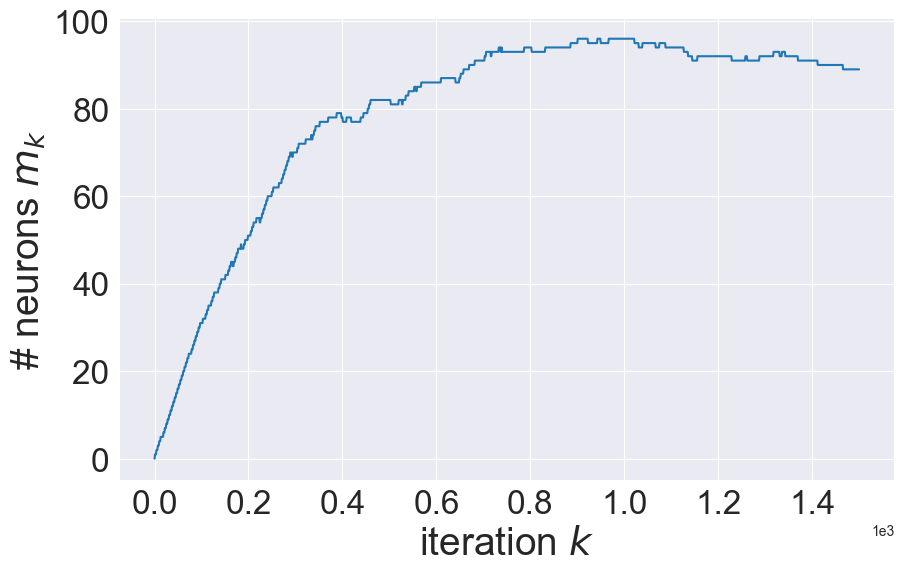

In [53]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(ms)), ms, label='$m_k$')

plt.xlabel('iteration $k$', fontsize=28)
plt.ylabel('# neurons $m_k$', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.savefig(os.path.join(FIGURES_DIR, 'complexity-ista-1-1.png'), bbox_inches='tight')
plt.show()

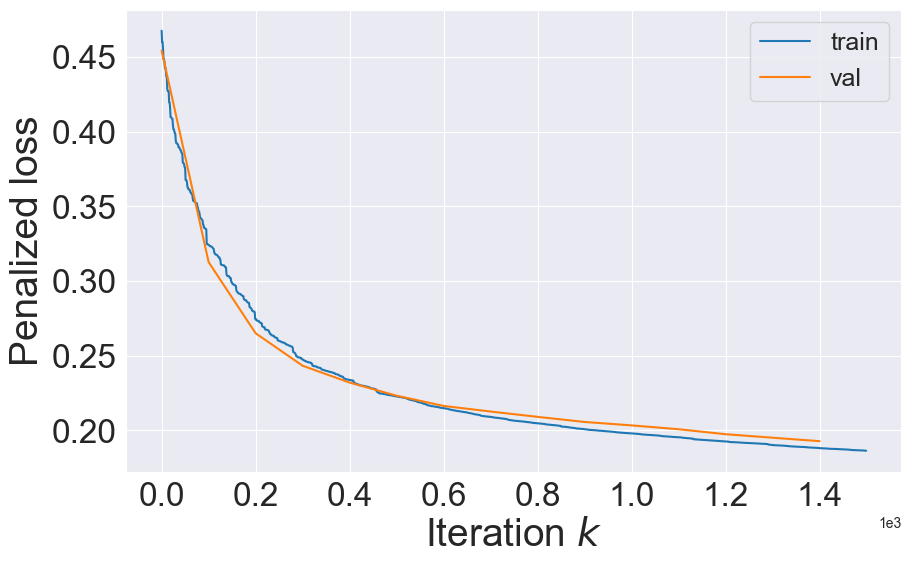

In [54]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(penalized_train_losses_mix_conic)), penalized_train_losses_mix_conic, label='train')
plt.plot([min(VAL_ITER * k, len(penalized_train_losses_mix_conic)) for k in range(len(penalized_val_losses))], 
         penalized_val_losses, label='val', marker=marker)

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Penalized loss', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

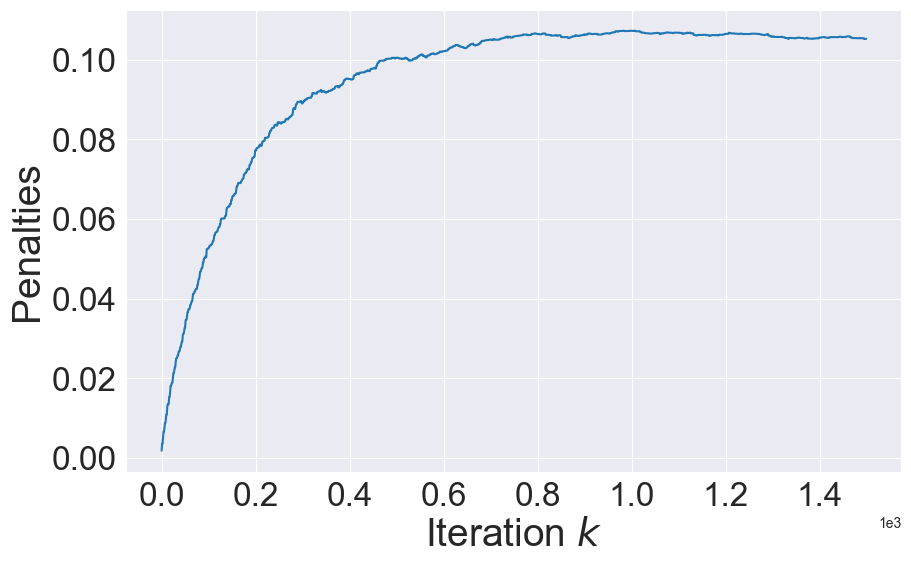

In [55]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

train_penalties = penalized_train_losses_mix_conic - train_losses_mix_conic

plt.plot(np.arange(len(train_penalties)), train_penalties, label='train')

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Penalties', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

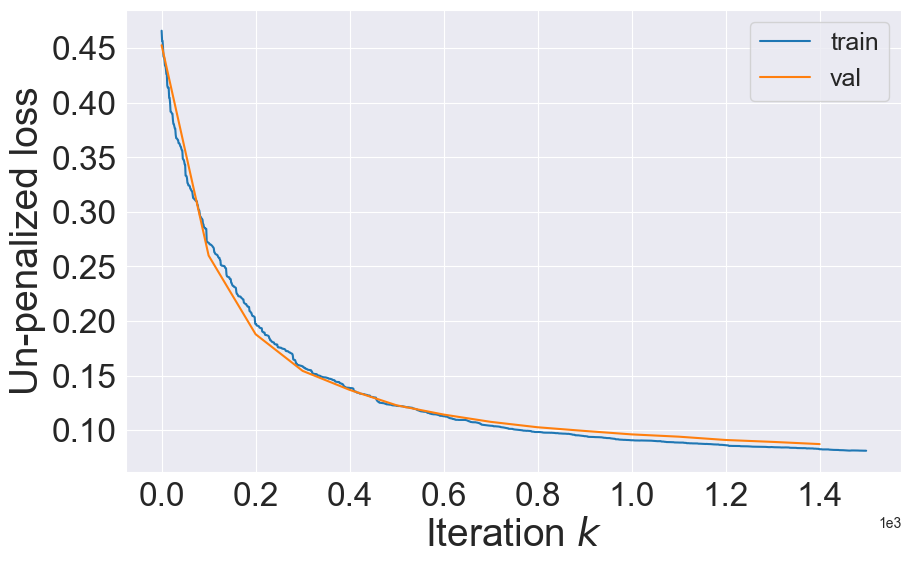

In [56]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(train_losses_mix_conic)), train_losses_mix_conic, label='train')
plt.plot([min(VAL_ITER * k, len(train_losses_mix_conic)) for k in range(len(val_losses))], val_losses, label='val',
         marker=marker)

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Un-penalized loss', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

## 6. Comparative results

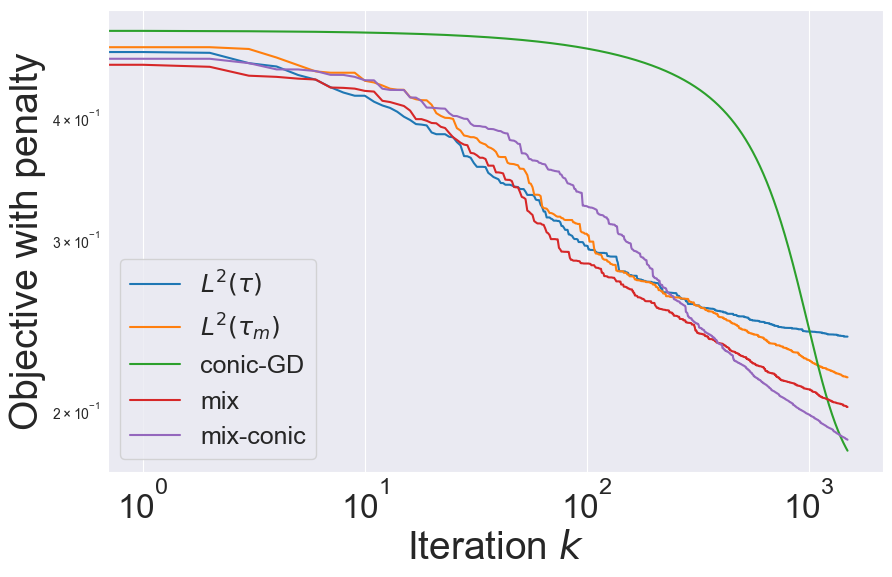

In [57]:
plt.figure(figsize=(10, 6))
marker = None #'o'
plt.xscale('log')
plt.yscale('log')

plt.plot(np.arange(len(penalized_train_losses_pop)), penalized_train_losses_pop, label='$L^2(\\tau)$')
plt.plot(np.arange(len(penalized_train_losses_coord)), penalized_train_losses_coord, label='$L^2(\\tau_m)$')
plt.plot(np.arange(len(penalized_train_losses_conic)), penalized_train_losses_conic, label='conic-GD')
plt.plot(np.arange(len(penalized_train_losses_mix)), penalized_train_losses_mix, label='mix')
plt.plot(np.arange(len(penalized_train_losses_mix_conic)), penalized_train_losses_mix_conic, label='mix-conic')
#plt.plot([min(VAL_ITER * k, len(penalized_train_losses_mix)) for k in range(len(penalized_val_losses))], 
#         penalized_val_losses, label='val', marker=marker)

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Objective with penalty', fontsize=28)
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'all_objectives_penalty_m={}.png'.format(m_star)), bbox_inches='tight')
plt.show()

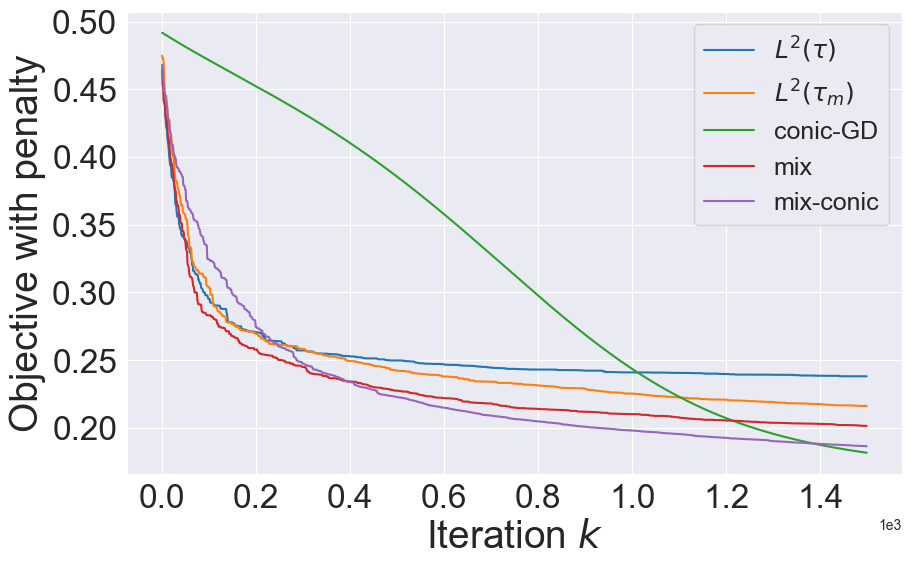

In [58]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(penalized_train_losses_pop)), penalized_train_losses_pop, label='$L^2(\\tau)$')
plt.plot(np.arange(len(penalized_train_losses_coord)), penalized_train_losses_coord, label='$L^2(\\tau_m)$')
plt.plot(np.arange(len(penalized_train_losses_conic)), penalized_train_losses_conic, label='conic-GD')
plt.plot(np.arange(len(penalized_train_losses_mix)), penalized_train_losses_mix, label='mix')
plt.plot(np.arange(len(penalized_train_losses_mix_conic)), penalized_train_losses_mix_conic, label='mix-conic')
#plt.plot([min(VAL_ITER * k, len(penalized_train_losses_mix)) for k in range(len(penalized_val_losses))], 
#         penalized_val_losses, label='val', marker=marker)

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Objective with penalty', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
plt.savefig(os.path.join(FIGURES_DIR, 'all_objectives_penalty_m={}.png'.format(m_star)), bbox_inches='tight')
plt.show()

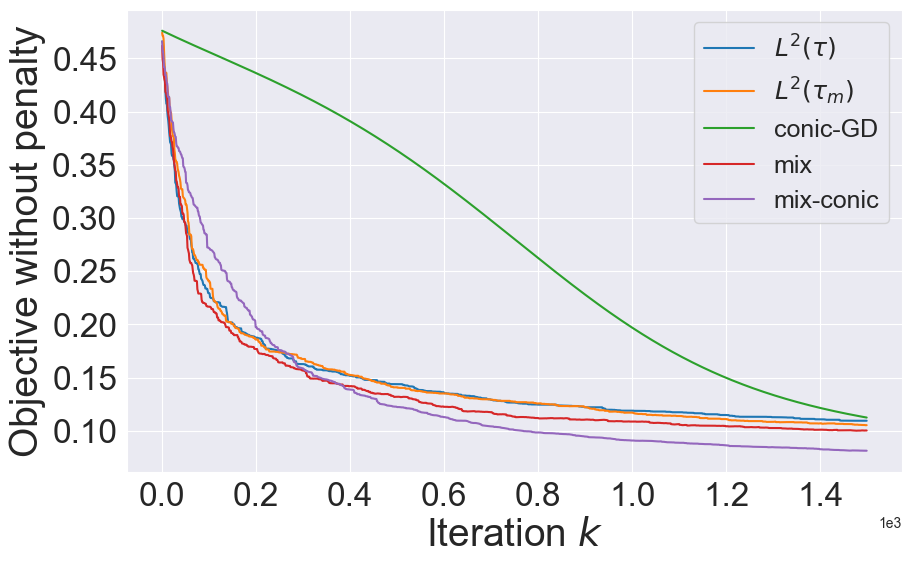

In [59]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(train_losses_pop)), train_losses_pop, label='$L^2(\\tau)$')
plt.plot(np.arange(len(train_losses_coord)), train_losses_coord, label='$L^2(\\tau_m)$')
plt.plot(np.arange(len(train_losses_conic)), train_losses_conic, label='conic-GD')
plt.plot(np.arange(len(train_losses_mix)), train_losses_mix, label='mix')
plt.plot(np.arange(len(train_losses_mix_conic)), train_losses_mix_conic, label='mix-conic')
#plt.plot([min(VAL_ITER * k, len(penalized_train_losses_mix)) for k in range(len(penalized_val_losses))], 
#         penalized_val_losses, label='val', marker=marker)

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Objective without penalty', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
plt.savefig(os.path.join(FIGURES_DIR, 'all_objectives_no_penalty_m={}.png'.format(m_star)), bbox_inches='tight')
plt.show()